In [6]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [36]:
df = pd.read_csv('hw_bootstrap.csv', sep=';')

In [37]:
# Заменим запятую на точку, чтобы привести к типу float
df['value'] = df.value.apply(lambda x: x.replace(',','.'))

In [38]:
df

,Unnamed: 0,value,experimentVariant
0,1,10.3804953740268,Control
1,2,9.54686666784264,Control
2,3,11.0882146509904,Control
3,4,10.1472740570122,Control
4,5,9.78980767524929,Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [39]:
df = df.astype({'value': 'float64'})


In [40]:
# t_test
stats.ttest_ind(df.query('experimentVariant == "Control"').value, df.query('experimentVariant == "Treatment"').value )

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

In [42]:
# U-test
stats.mannwhitneyu(df.query('experimentVariant == "Control"').value, df.query('experimentVariant == "Treatment"').value )

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [ ]:
# бутстрап средних

In [43]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

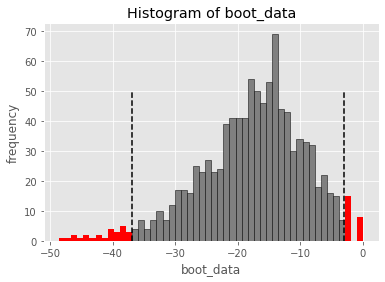

In [44]:
booted_data = get_bootstrap(df.query('experimentVariant == "Control"').value, df.query('experimentVariant == "Treatment"').value )

In [45]:
booted_data["p_value"]

0.03624093074374447

In [46]:
#Согласно бутстрапу и t-тесту, нужно отклонить нулевую гипотезу о том,
#что результаты контрольной группы не отличаются от тестовой.
#Следовательно, средние в группах сильно различаются
# U-тест даёт противоположный результат

SyntaxError: invalid syntax (<ipython-input-46-70b52d98e4da>, line 1)

In [18]:
df

0        10
1         9
2        11
3        10
4         9
       ... 
995    1000
996    1200
997    1500
998    2000
999    3000
Name: value, Length: 1000, dtype: object

# Ответ преподавателя


Верно следующее утверждение: Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки (иногда путают с равенством медиан, но на самом деле проверяется не только медиана). Также вы верно применили критерии и написали код


Про разное количество наблюдений в выборках: Манн-Уитни как и любой статистический оценщик не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект). Подробнее тут https://stats.stackexchange.com/questions/40342/mann-whitney-u-test-with-unequal-sample-sizes

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы

Хорошего дня!